In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pandas.tools.plotting import table
from datetime import datetime

%matplotlib inline
#plt.style.use('ggplot')

# Bajar y graficar los datos de la AFP

In [2]:
year = datetime.now().year # Presente año
url_data = 'https://cdn.rawgit.com/collabmarket/data_afp/master/data/VC-MODELO.csv'
afp_name = url_data.split('-')[-1].split('.')[0] # Nombre de la afp
afp = pd.read_csv(url_data, index_col=0, parse_dates=True) # Crea DataFrame con los datos
afp.dropna(inplace=True) # Elimina filas sin datos de para todos los fondos

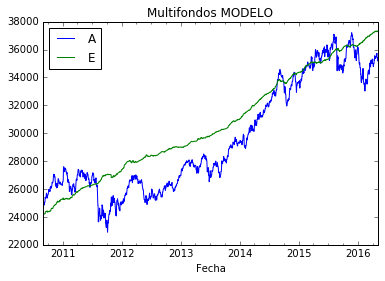

In [3]:
# Grafico sólo fondos A y E
afp.loc[:,['A','E']].plot(title='Multifondos %s'%(afp_name))

# Define parámetros base del modelo

El modelo se sustenta en la medida que existan períodos en que el valor cuota de A crece más que E, y después viene un período de corrección, en que el valor cuota de A es menor que E.
Existen varios supuestos cuya demostración escapa del alcance del modelo, pero se debe tener en cuenta para entender como funciona el mercado financiero
 1. El crecimiento del valor cuota de E es sostenido en el tiempo, esto implica que la renta fija siempre va a crecer en el tiempo y el crecimiento base de la economía es sustentable (Los países, bancos centrales y grandes corporaciones que emiten bonos, siempre serán solventes y responsables). Yo no pienso que esto sea posíble en un mundo finito y donde la concentración económica corrompe, pero en el mediano plazo la inercia económica mantiene este supuesto. 
 1. Aquellos agentes que trabajan directamente en las bolsas tienen grandes incentivos para que se "inflen" los precios de las acciones más allá del valor libro y después tienen mayores incentivos para que existan grandes caídas, en esto último sólo estos agentes tienen acceso a instrumentos financieros como ventas en corto y derivados que apuestan contra los grandes índices, donde se manejan volúmenes enormes y es donde se traspasa la riqueza con las grandes caídas.
 1. Es natural en la economía existan ciclos de crecimientos, crisis (cambio de tendencia) y caídas (corrección), además estos ciclos pueden ser amplificados por la acción de cambios bruscos de grandes agentes económicos, como la FED, la irrupción de China y un cambio brusco en el mercado del petróleo. El modelo aún no incluye la acción de estos agentes, pero en algún momento debería incorporarlo ([Riesgo Sistémicos](http://nbviewer.jupyter.org/github/collabmarket/algorithms_afp/blob/master/SystemicRisk.ipynb))

In [4]:
# Delta es Valor relativo (diferencia o resta) entre valores cuota de A y E
afp['delta'] = afp.A - afp.E

## Define Zero es Nivel indiferencia arbitrario
Incialmente el valor cuota de A y E no es necesariamente el mismo, por lo que el nivel de indiferencia no es cero, por lo cual se eligen dos niveles de indiferencia uno de mediano plazo y uno de largo plazo

In [5]:
# Elegimos un nivel de indiferencia de largo plazo
# Propuesta 1 (utilizada):
# Suponenos que a los 365 dias de inicio de los multifondos cumplen Hipotesis del mercado eficiente
# pero con el tiempo los fondo se sobrevalora o subvalora de acuerdo al ciclo económico
# Propuesta 2 (no implementada):
# Ajuste linea de tendencia mínimos locales ultimos años anteriores
# No se usa en la estrategia, pero se pone como referencia
zero = afp.delta[365]

### Define nivel de indiferencia de mediano plazo

In [6]:
# Parametros: ['median',365] (elejimos mediana movil 365 dias)
afp['zero'] = afp.delta.rolling(window=365,center=False).median()
# Supuestos:
# Zero representa valor relativo fondo A comparable con E
# fondo E refugio A es como una pseudo Inverse exchange-traded cuando hay alta volatilidad
# Cambios entre renta variable (fondo A) y renta fija (fondo E)
# Estrategia objetivo "comprar barato y vender caro"
print "Describe zero %s:"%(afp_name)
print afp.zero.describe()

Describe zero MODELO:
count    1709.000000
mean    -1267.259029
std      1042.073197
min     -2571.720000
25%     -2253.040000
50%     -1595.060000
75%      -129.440000
max       963.210000
Name: zero, dtype: float64


## Grafico de tendencia Delta diferencia entre A y E con nivel de indiferencia Zero

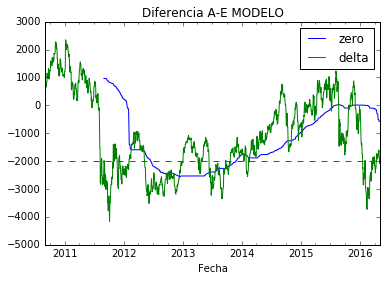

In [7]:
# Grafico de tendencia Delta diferencia entre A y E con nivel de indiferencia Zero
afp[['zero','delta']].plot(title='Diferencia A-E %s'%(afp_name))
plt.axhline(y=zero, color='r', linestyle='--')

### Observaciones Grafico de tendencia Delta diferencia entre A y E

Se observa que hay una tendencia en que 'delta' converge a valor cercano a 0, cada vez es menos atractiva la estrategia de cambio de fondo entre A y E, pues variabilidad de 'delta' tienden a ser mas frecuentes y de menor aplitud.

# Estrategias de cambio de Fondos

## Tipos de estrategias

### Estrategias "ex post" (Basada en datos actuales en lugar de pronosticos)

Estrategia "Evitar perdidas" (ejemplo: Felices y Forrados)
Es muy dificil pues caidas son mas abruptas que subidas, consiste en mantenerse en A y refujiar en E implica aplicar "stop lost" algo muy dificil de implementar por la lentitud de los plazos cambio de fondo de las AFP.

### Estrategia propuesta "Aprovechar recuperacion"

Dado que subida es mas lenta que caida mas acorde con lentitud de cambios de fondo, consiste en mantenerse en E y despues de una gran caida entrar a A para aprovechar recuperacion, implica aplicar un criterio arbitrario de "entrada" que define gran caida e inicio recuperacion.

Luego del periodo de recuperacion se sale de A mientras la probabilidad de recuperacion sea alta, implica aplicar "stop gain" se debe elegir un criterio arbitrario de "salida".

### Criterios propuestos de salida:

- Nivel de delta con probabilidad de recuraperacion acotada (tiene problema caso "recuperacion aparente")
- Una rentabilidad (recuperacion) objetivo proporcional a la reciente caida

Dado que variaciones de delta tienden a ser mas frecuentes y de menor aplitud, esta estrategia tambien es cada vez mas dificil de implementar por la lentitud de cambios de fondo de las AFP.

### Estrategia dual "Evitar perdidas y Aprovechar recuperaciones"

Entre el 2004 y el 2012 esta estrategia pudo aprovecharse ya que variacion tendencia de delta, fue en ciclos grandes de gran amplitud, a partir del 2012 variacion tendencia delta es de ciclos cortos y baja amplitud, por lo que solo la estrategia de aprovechar recuperacion es atractiva, pero tambien tiende a ser menos rentable.

### Estrategias "ex ante" (Basada en pronósticos en lugar de datos actuales)

En teoria se podria hacer ambas estrategias evitar caidas del A y aprovechar recuperaciones del A, si alguien pudiera "predecir" cambios de tendencia en los mercados en el mediano plazo (semanas, meses) seria factible, pero nadie a demostrato un metodo consistente para lograr eso, el "market timing" funciona entre menor sea el plazo hasta llegar a casos extremos como el High-frequency trading (HFT).

## Define categoría (etiqueta) 'valorA'

Compara delta con respecto a zero:
- Valor de A es relativamente mas alto que E  [delta > zero]
- Valor de A es relativamente mas bajo que E [delta < zero]

In [8]:
# Categoría (etiqueta) 'valorA'
afp['valorA'] = pd.np.where(afp['delta'] < afp['zero'], 'bajo', 'alto')
afp['bajo'] = afp.delta[afp.delta<afp.zero]
afp['alto'] = afp.delta[afp.delta>afp.zero]

### Observaciones sobre 'valorA'
Después de una caida de A la probabilidad de ganacia E->A es alta (recuperacion), pues se supone que renta variable en promedio genera mas valor que renta fija, pero para eso es necesario detectar minimo local de valor de A.

__Warning: "Probabilidad de ganancia E->A" != 1-"Probabilidad de perdida de A"__

Antes de grandes caidas, hay mucha volatilidad con recuperaciones "aparentes", que preceden grandes caidas, por eso es necesario ademas tener datos de riesgo sistemico. Casos:
- Inicio 2008 (Recuperación, seguida por gran caída)
- Fin del 2015 (Recuperación y caída inicio 2016)

### Grafico frecuencia categorias de 'valorA'

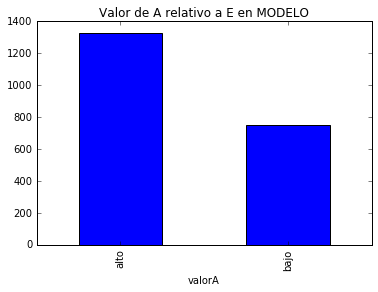

In [9]:
# Cuenta dias en que valor de A es alto y bajo con respecto a E
afp.groupby('valorA').delta.count().plot(kind='bar', title='Valor de A relativo a E en %s'%(afp_name))

### Observaciones Grafico frecuencia categorias de 'valorA'
Del gráfico se puede observar que es más frecuente que valor fondo A sea mayor con respecto a el fondo E, entonces es posible suponer que las recuperaciones demoran más tiempo que las caídas.
Se tiene más tiempo para aprovechar eventos puntuales de recuperacion valores minimos de A con respecto a E.

### Grafico delta clasificado por 'valorA'

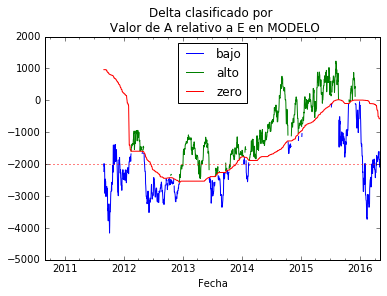

In [10]:
afp.loc[:,['bajo','alto','zero']].plot(title='Delta clasificado por \n Valor de A relativo a E en %s'%(afp_name))
plt.axhline(y=zero, color='r', linestyle=':')

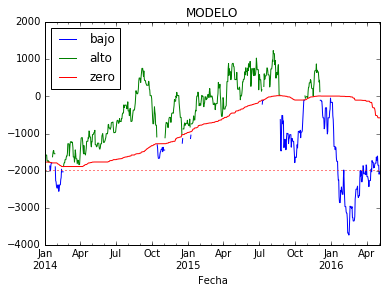

In [11]:
# Zoom desde dos años al presente
init = str(year - 2)
afp.loc[init:,['bajo','alto','zero']].plot(title='%s'%(afp_name))
plt.axhline(y=zero, color='r', linestyle=':')

## Define parámetros moviles estrategia Estrategia 
"Aprovechar recuperacion" y "Evitar perdidas" con stop gain

In [12]:
## Estrategia "Aprovechar recuperacion" y "Evitar perdidas" con stop gain
# Criterios de Entrada a renta variable
# Parametros: ['quantile',0.1,365] (elejimos cuantil 10% ventana 365 dias)
afp['entra'] = afp.delta.rolling(window=365,center=False).quantile(quantile=0.1)
# Criterios de Salida a renta fija
# Parametros: ['quantile',0.9,365] (elejimos cuantil 90% ventana 365 dias)
afp['sale'] = afp.delta.rolling(window=365,center=False).quantile(quantile=0.9)
# Criterio rentabilidad de corto plazo (15 dias)
afp['rate'] = afp.delta.pct_change(15)

### Graficar delta con limites entra, sale, zero movil y zero largo plazo

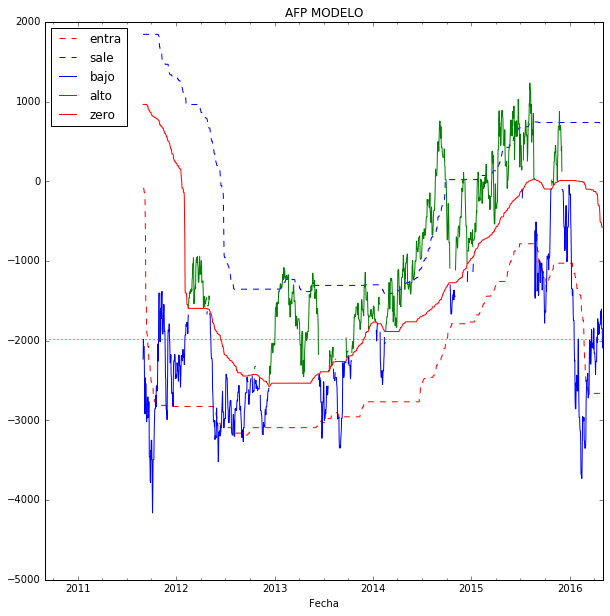

In [13]:
ax = afp.loc[:,['entra','sale']].plot(title='AFP %s'%(afp_name), style=['--r','--b'])
afp.loc[:,['bajo','alto','zero']].plot(title='AFP %s'%(afp_name), figsize=(10,10), style=['b','g','r'], ax=ax)
ax.axhline(y=zero, color='r', linestyle=':')

## Definicion reglas de la estrategia
Crea la categoría 'estrategia' donde se van a clasificar los días como 'E', 'A', 'E->A', 'A->E' y 'S/I' (Sin información)

In [14]:
# Caso base se marca como desconocido, Sin Informacion (S/I)
afp['estrategia'] = 'S/I'
# Señales de largo plazo 
afp.loc[afp.delta < afp.zero,'estrategia'] = 'E'
afp.loc[afp.delta > afp.zero,'estrategia'] = 'A'

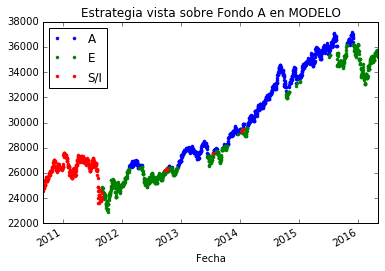

In [15]:
# Grafico estrategia base
gb = afp[['A','B','C','E','estrategia']].groupby('estrategia')
fig, ax = plt.subplots()
gb.A.plot(style='.', title='Estrategia vista sobre Fondo A en %s'%(afp_name),ax=ax)
plt.legend(loc=2)

In [16]:
# Señales de mediano plazo
# Fuerte subida cuando el 'valorA' es muy caro con respecto a E 
afp.loc[(afp.delta > afp.entra) & (afp.delta < afp.zero) & (afp.rate > 1),'estrategia'] = 'E->A'
# Fuerte caída cuando 'valorA' es muy caro con respeto a E
afp.loc[(afp.delta > afp.sale) & (afp.rate < -1),'estrategia'] = 'A->E'

### Grafico cuantos dias se esta en cada opción de la estrategia

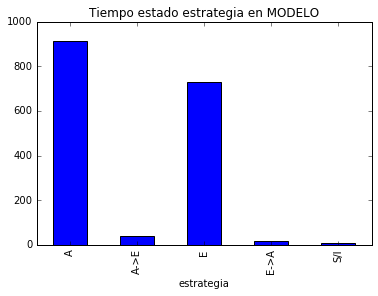

In [17]:
# Clasifica de acuerdo a 'estrategia' y cuenta numeros de días en cada 
afp.groupby('estrategia').count()['zero'].plot(kind='bar', title='Tiempo estado estrategia en %s'%(afp_name))

### Para interpretar las señales
- Los cambios de fondo (A->E y E->A) son indicio de cambio tendencia
- Los días S/I, es cuando no existe una tendencia clara
- El cambio se consolida cuando aparece el fondo de destino
### ADVERTENCIA
_El algoritmo no entrega señales 100% claras, por lo que no es recomendable su uso para gestionanr fondos AFP, sin una correcta interpretación de las tendencias y datos de riesgo sistémico_


In [18]:
# Agrupar por la categoría 'estrategia'
gb = afp[['A','B','C','E','estrategia']].groupby('estrategia')

### Grafico 'estrategia' sobre A

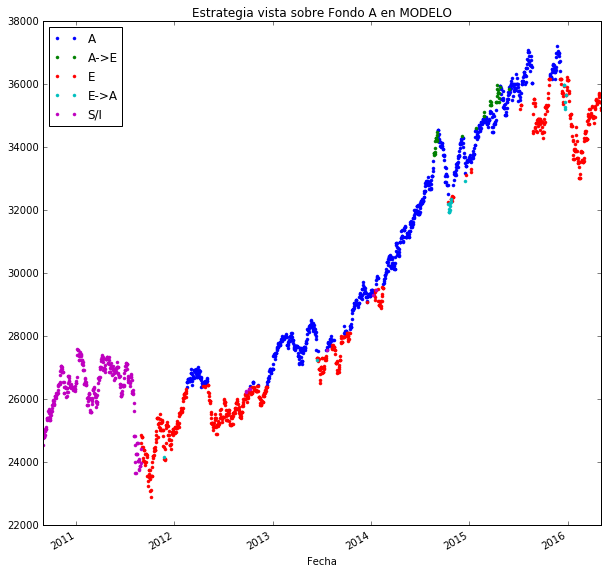

In [19]:
# Grafica 'estrategia' sobre A
fig, ax = plt.subplots()
gb.A.plot(style='.', figsize=(10,10), title='Estrategia vista sobre Fondo A en %s'%(afp_name),ax=ax)
plt.legend(loc=2)
fig.savefig('result/A-E_%s-large.png'%(afp_name))

### Zoom Grafico ultimo año 'estrategia' sobre A

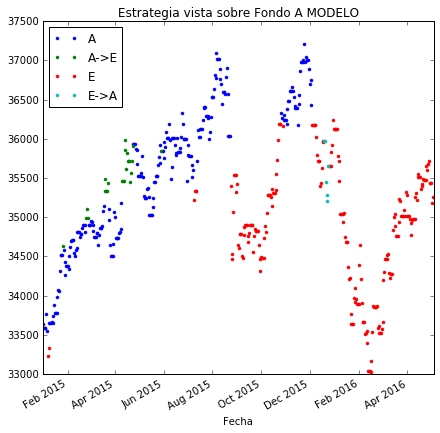

In [20]:
# Grafica estrategia sobre fondo='A' desde init al presente
init = str(year - 1)
fondo = 'A'
fig, ax = plt.subplots()
for k, group in gb:
    df = group.loc[init:, fondo] 
    if len(df) != 0: # Evita error Empty 'DataFrame'
        df.plot(style='.', figsize=(7,7), title='Estrategia vista sobre Fondo %s %s'%(fondo, afp_name), ax=ax, label=k)
ax.legend(loc=2)
fig.savefig('result/A-E_%s.png'%(afp_name))

### ADVERTENCIA
El algoritmo no entrega señales 100% deterministas, por lo que no es recomendable aún su uso para gestionanr fondos AFP.
Requiere hacer un método estocástico para "filtrar" las señales de cambio de fondo de las caídas pequeñas, no así con las caídas grandes.


### Tabla últimos 15 dias de estrategia

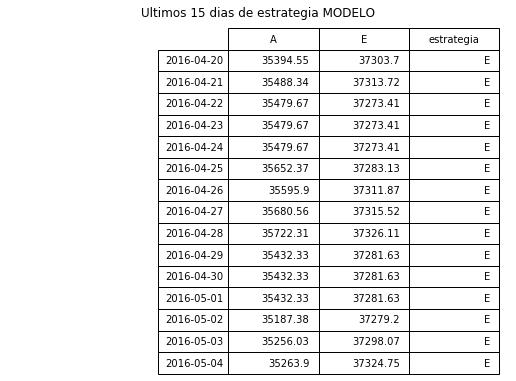

In [21]:
# Tabla últimos 15 dias de estrategia
df = afp.iloc[-15:][['A','E','estrategia']]
df.index = [item.strftime('%Y-%m-%d') for item in df.index]

fig, ax = plt.subplots(figsize=(9, 6)) # set size frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.set_frame_on(False)  # no visible frame
tabla = table(ax, df, loc='upper right', colWidths=[0.1]*len(df.columns))
tabla.scale(1.8, 1.8)
plt.title('Ultimos 15 dias de estrategia %s'%(afp_name))
plt.savefig('result/A-E_%s_table.png'%(afp_name))

In [22]:
#%qtconsole